In [175]:
import pandas as pd
import numpy as np
import os

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Train/Test splitting
from sklearn import model_selection

# Hyper-parameter tuning
from sklearn.model_selection import RandomizedSearchCV,  GridSearchCV, cross_val_score

# Classifiers
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Classifier evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer, confusion_matrix, classification_report

# Print confusion matrix
import seaborn as sns

In [176]:
# Get relevant file paths
project_root = os.path.dirname(os.getcwd())
fall_18_data_path = project_root + '/Data/Fall_2018/'
fall_19_data_path = project_root + '/Data/Fall_2019/'

In [177]:
# Read in excel file with recipient gender hand labeled 
df_fall_18_messages = pd.read_excel(fall_18_data_path + 'FA18_messages_with_gender_recipients_hand_lableled.xlsx', index_col=0)
print(df_fall_18_messages.shape)
df_fall_18_messages.head()

(5039, 5)


,User ID,Sender Race,Sender Gender,Recipient Gender,Text
0,42683026,WHITE,F,F,Hey @Katie Poteet I know you said we should em...
1,25501571,WHITE,F,F,@Mary Cassell I would email Dr. K anyway with ...
2,42683026,WHITE,F,F,"Ok, thanks a lot. I have the email typed but w..."
3,25501571,WHITE,F,F,Upstairs from our lecture hall
4,25501571,WHITE,F,F,Sherman 207!!!


In [180]:
# Encode recipient gender char as int and create as new column in dataframe
# Remove rows where recipient's gender is unknown
male_val = 0
female_val = 1
neutral_val = 2

def encode(c):
    if (c == 'M'):
        return male_val
    elif (c == 'F'):
        return female_val
    elif (c == 'N'):
        return neutral_val

# Add column in dataframe for encoded gender
df_fall_18_messages['Recipient Gender Encoded'] = [encode(x) for x in df_fall_18_messages['Recipient Gender']]
# Drop nas (some genders were unknown in the dataset)
df_fall_18_messages = df_fall_18_messages[df_fall_18_messages['Recipient Gender Encoded'].notna()]
print(df_fall_18_messages.shape)
df_fall_18_messages.head()

(4872, 6)


,User ID,Sender Race,Sender Gender,Recipient Gender,Text,Recipient Gender Encoded
0,42683026,WHITE,F,F,Hey @Katie Poteet I know you said we should em...,1
1,25501571,WHITE,F,F,@Mary Cassell I would email Dr. K anyway with ...,1
2,42683026,WHITE,F,F,"Ok, thanks a lot. I have the email typed but w...",1
3,25501571,WHITE,F,F,Upstairs from our lecture hall,1
4,25501571,WHITE,F,F,Sherman 207!!!,1


In [181]:
# Get feature vector X and target label y 
fa_18_message_array = df_fall_18_messages['Text'].values
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(fa_18_message_array)
y = df_fall_18_messages['Recipient Gender Encoded']

In [182]:
# Print y shape and number of instances of each label
print(y.shape)
print(y.value_counts())

(4872,)
2    2011
1    1517
0    1344
Name: Recipient Gender Encoded, dtype: int64


In [184]:
# Split data into training and test sets (75:25 training testing ratio)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, shuffle = True)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (3654, 4653)
y_train: (3654,)
X_test: (1218, 4653)
y_test: (1218,)


In [252]:
def get_best_estimator(clf, params):
    # Metrics to use for optimization
    # metrics = ['accuracy','f1', 'f1_macro', 'f1_weighted','precision','recall']
    
    # Optimize based on f1_macro score
    grid_search = GridSearchCV(clf, param_grid = params, cv = 10, n_jobs = -1, scoring = 'f1_macro', verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Get estimator with best parameter valuese
    best_estimator = grid_search.best_estimator_
    
    # Print results
    print("Best parameters set found on training set:\n", grid_search.best_params_)
    print("Grid scores on training set:\n")
    print(grid_search.cv_results_)
    print(best_estimator)
    
    # Return best_estimator
    return best_estimator 

In [253]:
def print_results(clf, y_pred):
    # Print accuracy score 
    print("Accuracy Score -> ",accuracy_score(y_pred, y_test)*100)
    
    # Print confusion matrix (heat map)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
    print(classification_report(y_test, y_pred))
    
    # Print avarage 10-fold cross validation accuracy and f1 scores 
    svm_cv_accuracy_score = cross_val_score(clf, X_train, y_train, cv=10,scoring='accuracy')
    svm_cv_f1_score = cross_val_score(clf, X_train, y_train, cv=10,scoring='f1_macro')
    print("Mean cv accuracy: ", svm_cv_accuracy_score.mean())
    print("Mean cv f1_macro: ", svm_cv_f1_score.mean())

In [254]:
def svm():
    # Parameters to optimize for svm
    param_grid = {'probability': [True],
                  'C': [1, 10, 100, 1000],
                  'kernel': ['rbf', 'poly', 'linear'],
                  'gamma': ['auto', 'scale', 0.1, 0.01, 0.001, 0.0001],
                 }
    # Get optimized parameters from grid search
    svm_clf = SVC(probability=True, kernel='rbf')
    optimized_svm_clf = get_best_estimator(svm_clf, param_grid)
    optimized_svm_clf.fit(X_train, y_train)
    
    # predict recipient gender and print prediction results
    y_pred = optimized_svm_clf.predict(X_test)
    print_results(optimized_svm_clf, y_pred)   

In [255]:
def random_forest():
    # Parameters to optimize for rf
    param_grid = {
        'max_depth': [10, 50, 100],
        'min_samples_leaf': [3, 5],
        'min_samples_split': [2, 4, 10],
        'n_estimators': [100, 200, 500]
    }
    
    # Get optimized parameters from grid search
    rf_clf = RandomForestClassifier()
    optimized_rf_clf = get_best_estimator(rf_clf, param_grid)
    optimized_rf_clf.fit(X_train, y_train)
    
    # predict recipient gender and print prediction results
    y_pred = optimized_rf_clf.predict(X_test)
    print_results(optimized_rf_clf, y_pred)  

In [259]:
def mlp():
    # Parameters to optimize for rf
    param_grid = {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive'],
        'max_iter': [2000]
    }
    
    # Get optimized parameters from grid search
    mlp_clf = MLPClassifier()
    optimized_mlp_clf = get_best_estimator(mlp_clf, param_grid)
    optimized_mlp_clf.fit(X_train, y_train)
    
    # predict recipient gender and print prediction results
    y_pred = optimized_mlp_clf.predict(X_test)
    print_results(optimized_mlp_clf, y_pred) 

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Best parameters set found on training set:
 {'C': 100, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}
Grid scores on training set:

{'mean_fit_time': array([10.81279542,  7.91097424,  8.99636939, 10.19486299, 10.368805  ,
        8.36980784,  8.89775298,  8.3126277 ,  9.17658215,  9.2042758 ,
        7.76607652,  8.69986773,  9.28747468,  8.34736881,  8.3128206 ,
        7.95592294,  7.43948224,  8.03992105,  8.49615057,  7.32489049,
       12.27720835, 10.47303164,  9.71240082, 12.27034509,  9.11347485,
       11.70268936, 21.64674215, 12.83347602, 12.37437372, 22.26961482,
       12.4841665 ,  7.82690685, 13.16057653,  8.85762372,  7.76026666,
       14.34850633, 15.09816489,  8.7770051 , 22.83840714, 12.2562598 ,
       11.24498084, 24.76058226, 17.73460405, 11.80032625, 28.82194707,
       11.7335819 ,  8.99033608, 23.93033302, 11.12763524, 10.8416347 ,
       27.36186092, 11.70894754,  8.99251609, 21.42397299,

SVM Accuracy Score ->  52.70935960591133
              precision    recall  f1-score   support

           0       0.46      0.32      0.38       343
           1       0.46      0.47      0.46       372
           2       0.59      0.71      0.65       503

    accuracy                           0.53      1218
   macro avg       0.51      0.50      0.50      1218
weighted avg       0.52      0.53      0.52      1218

Mean cv accuracy:  0.5117568680290441
Mean cv f1_macro:  0.4793575399244606


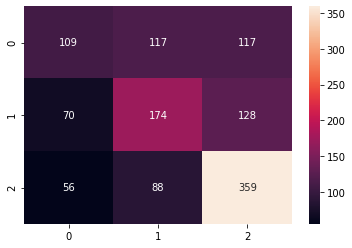

In [239]:
svm()

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Best parameters set found on training set:
 {'max_depth': 100, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 500}
Grid scores on training set:

{'mean_fit_time': array([ 0.56907089,  1.11334865,  2.84131746,  0.63852165,  1.29862993,
        3.34283516,  0.64836974,  1.31031508,  3.10838532,  0.63795934,
        1.2074369 ,  3.17000175,  0.69267619,  1.30564179,  3.29024155,
        0.6745141 ,  1.51665902,  3.20563812,  1.61896992,  3.29161026,
        8.75682452,  1.78976026,  3.97825253, 10.10101471,  1.92472303,
        3.66528435,  9.53999212,  1.41314461,  2.82807395,  7.36741197,
        1.42328098,  2.7495779 ,  6.97311382,  1.68835738,  3.13703873,
        7.62310984,  2.10177379,  4.02534027, 10.3297344 ,  2.07233129,
        4.40952873, 10.87857971,  2.23072729,  4.29566853, 10.78163102,
        1.60728171,  3.29856718,  8.13626833,  1.57464778,  3.36971772,
        8.21719639,  1.59004016,  3.2

SVM Accuracy Score ->  47.61904761904761
              precision    recall  f1-score   support

           0       0.46      0.08      0.13       343
           1       0.40      0.38      0.39       372
           2       0.51      0.82      0.63       503

    accuracy                           0.48      1218
   macro avg       0.46      0.43      0.38      1218
weighted avg       0.46      0.48      0.42      1218

Mean cv accuracy:  0.5114858896623999
Mean cv f1_macro:  0.4196376939169043


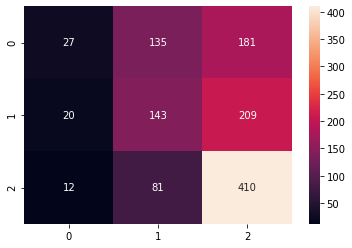

In [247]:
random_forest()

Fitting 10 folds for each of 48 candidates, totalling 480 fits


/Users/saratahir/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters set found on training set:
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 2000, 'solver': 'sgd'}
Grid scores on training set:

{'mean_fit_time': array([105.39285142,  15.35014446, 113.63527844,  15.01745727,
       115.4961446 ,  17.15353358, 132.58692439,  18.6137187 ,
       446.79672537,  85.23344061, 451.48428922,  91.34848087,
       126.2523046 ,  15.19345629, 131.94760056,  14.13885524,
       138.03101532,  15.44045222, 181.94354331,  18.15633976,
       556.98360476,  75.62268376, 512.69050255,  61.99762068,
         2.97436299,  13.19668229,   8.82650816,  11.56472454,
         2.96397893,  11.55659359,   9.1674144 ,  12.47187059,
       498.94265358, 101.61924572, 537.72773736,  84.82385352,
         2.88222523,  13.18865635,   8.91289442,  13.62771661,
         3.02833498,  15.45086553,   9.65288324,  14.68722413,
       474.50505607, 100.36164355, 687.68787842,  89.17086868]), 'std_fit_time': ar

/Users/saratahir/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy Score ->  53.77668308702791
              precision    recall  f1-score   support

           0       0.49      0.37      0.42       343
           1       0.47      0.52      0.49       372
           2       0.61      0.67      0.64       503

    accuracy                           0.54      1218
   macro avg       0.52      0.52      0.52      1218
weighted avg       0.53      0.54      0.53      1218



/Users/saratahir/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saratahir/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saratahir/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saratahir/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saratahir

Mean cv accuracy:  0.5068448237143499
Mean cv f1_macro:  0.48192593745684587


/Users/saratahir/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


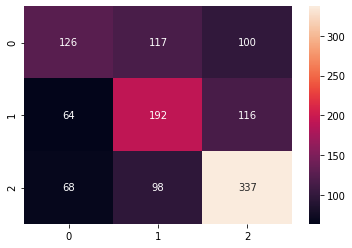

In [260]:
mlp()